In [2]:
#%matplotlib inline # 使得绘图在notebook中显示，VSCode里面不需要这个
import random
import torch
from typing import Tuple 
from d2l import torch as d2l

/home/lemon/anaconda3/envs/d2l-zh/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/lemon/anaconda3/envs/d2l-zh/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def synthetic_data(w: torch.Tensor, b: float, num_examples: int) -> Tuple[torch.Tensor, torch.Tensor]: 
    '''用于生成数据集，y = Xw + b + 噪声

    Args:
        w (torch.Tensor): weight，权重
        b (float): bias，偏差
        num_examples (int): number of examples，样本数

    Returns:
        torch.Tensor: data，数据集
    '''
    X: torch.Tensor = torch.normal(0, 1, (num_examples, w.shape[0])) # 生成均值为0，方差为1的正态分布，维度为(num_examples, len(w))，这将作为新的输入
    y: torch.Tensor = torch.matmul(X, w) + b # 矩阵乘法，这将作为新的输出
    # 此时y的维度为(num_examples, 1)。这样生成出来的y过于标准，所以加上噪声
    y += torch.normal(0, 0.01, y.shape)
    y = y.reshape((-1, 1)) # 转置，此时y的维度为(1, num_examples)，-1表示自动推断
    return X, y


In [4]:
ground_true_w: torch.Tensor = torch.tensor([2, -3.4]).reshape((2, 1)) # 真实的权重
ground_true_b: float = 4.2 # 真实的偏差
features, labels = synthetic_data(ground_true_w, ground_true_b, 1000) # 生成数据集
features, labels, features.shape, labels.shape

(tensor([[ 0.1442, -0.6002],
         [-0.9462, -0.2500],
         [-0.3543, -0.7700],
         ...,
         [ 0.5064,  0.3544],
         [ 0.0132,  0.8532],
         [-0.0402,  0.4778]]),
 tensor([[ 6.5164e+00],
         [ 3.1601e+00],
         [ 6.1264e+00],
         [ 6.4048e+00],
         [ 8.0719e+00],
         [ 7.3454e+00],
         [ 7.4071e+00],
         [ 1.1038e+01],
         [ 4.9487e-01],
         [ 7.2371e+00],
         [ 4.3368e+00],
         [ 5.3564e+00],
         [-3.6050e+00],
         [ 9.5523e+00],
         [ 7.8747e+00],
         [ 5.0934e+00],
         [-2.5508e+00],
         [ 1.0477e+01],
         [ 5.1107e+00],
         [-2.7235e+00],
         [ 5.7068e+00],
         [ 2.3128e-01],
         [ 3.5390e+00],
         [ 1.2348e+01],
         [ 1.2643e+01],
         [ 3.3706e+00],
         [ 6.4674e+00],
         [ 6.7841e+00],
         [ 4.2199e+00],
         [ 1.0161e+01],
         [ 2.5578e-01],
         [ 8.7505e+00],
         [ 5.8294e+00],
         [ 2.5447e

In [5]:
print(f'features: {features[0]}, label: {labels[0]}') # 打印第一个样本

features: tensor([ 0.1442, -0.6002]), label: tensor([6.5164])


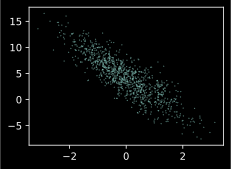

In [6]:
d2l.set_figsize() # 设置图像大小，默认是(3.5, 2.5)。这里3.5是横轴，2.5是纵轴
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 0.05); # 绘制散点图
# 参数的意思是：横轴是features的第二列，纵轴是labels，点的大小是1。这里的detach()是为了将tensor转换为numpy。这里的分号是为了不显示多余的输出。
# 可以多尝试几个features的列，看看效果。不detach()的话，目前似乎也是可以的。

In [7]:
def data_iter(batch_size: int, features: torch.Tensor, labels: torch.Tensor) -> Tuple[torch.Tensor]:
    '''通过给定的features和labels，每次小批量的返回数据，作为训练

    Args:
        batch_size (int): 每次返回的批量大小。当剩余record不足的时候，按照最大返回
        features (torch.Tensor): 输入的全部features
        labels (torch.Tensor): 输入的全部labels
    Returns:
        Tuple[torch.Tensor]: 返回的batch
    '''
    num_examples: int = features.shape[0] # feature的大小
    indices: list[int] = list(range(num_examples)) # 生成一个从0到num_examples的list，目的是为了打乱顺序。而打乱顺序的目的是为了让每次的batch都是随机的。
    random.shuffle(indices) # 打乱顺序，这里的shuffle是in-place的，也就是说，它会直接修改原来的list
    for i in range(0, num_examples, batch_size): # 这里的意思是：从0开始，每次增加batch_size，直到超过num_examples。i是每次的起始位置
        batch_indices: torch.Tensor = torch.tensor(indices[i: min(i + batch_size, num_examples)]) # 这里的意思是：从i开始，每次增加batch_size，直到超过num_examples。这里的min是为了防止超过num_examples
        yield features[batch_indices], labels[batch_indices] # 返回每次的batch
        # yield的意思是：每次返回一个batch，但是不会退出函数。而return的意思是：每次返回一个batch，然后退出函数。
        # 事实上，这里是把我们输入的features和labels给转化成了某种可以迭代的形式，然后每次返回一个batch。这样就可以在for循环里面使用了。


In [8]:
batch_size: int = 5 # 每次返回的批量大小
for X, y in data_iter(batch_size, features, labels): # 这里我们就迭代了
    print(X)
    print(y)
    break # debug用途，看一下就好

tensor([[ 0.5518, -0.5457],
        [ 0.3761,  1.1572],
        [-0.1355, -0.0764],
        [ 0.8829, -0.1086],
        [ 0.3102, -0.0035]])
tensor([[7.1682],
        [1.0202],
        [4.1965],
        [6.3264],
        [4.8414]])


In [9]:
w: torch.Tensor = torch.normal(0, 0.01, size=(2, 1), requires_grad=True) # 初始化权重，维度为(2, 1)，均值为0，方差为0.01。
# 我们在这里实现的是一个单层的线性回归模型，所以只有一层权重。如果是多层的话，那么就会有多个权重。
# 这里的requires_grad=True是为了后面的梯度计算。我们的目的是要让w和b不断的梯度下降，从而达到最优的效果。
b: torch.Tensor = torch.zeros(1, requires_grad=True) # 初始化偏差，维度为(1, 1)，为全0

In [10]:
def linreg(X: torch.Tensor, w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    '''线性回归模型

    Args:
        X (torch.Tensor): 输入的features
        w (torch.Tensor): 权重
        b (torch.Tensor): 偏差

    Returns:
        torch.Tensor: 输出的预测值
    '''
    return torch.matmul(X, w) + b # 矩阵乘法，这就是整个网络了，Y = XW + b


In [11]:
def squared_loss(y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    '''均方误差

    Args:
        y_hat (torch.Tensor): 预测值
        y (torch.Tensor): 真实值

    Returns:
        torch.Tensor: 均方误差
    '''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / (2 * y_hat.shape[0]) # 这里的y_hat.shape[0]是为了求多个record的平均值
    # 使用latex来表达公式的话，这里的公式是：$\frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$，其中n是y_hat的第一维度，也就是样本的数量。

In [12]:
def sgd(params: list, lr: float, batch_size: int) -> None: # sdg的全称是stochastic gradient descent，也就是随机梯度下降
    '''随机梯度下降

    Args:
        params (list): 需要更新的参数，包括了w和b
        lr (float): 学习率，learning rate
        batch_size (int): 每次的batch大小
    
    '''
    with torch.no_grad(): # 这里的with是为了防止后面的操作被记录到计算图中，从而影响梯度计算
        for param in params: # 遍历每个参数
            param -= lr * param.grad # 更新参数
            param.grad.zero_() # 梯度清零，这样子下一轮操作就不会跟上一轮相关。这里的_是为了in-place操作
    

那对于这个简单的单层线性回归网络而言，前期的准备工作大概是这样的：
1. 首先，我们需要定义网络的结构，即网络的输入和输出，以及网络中的参数。在这里我们通过定义了函数linreg来实现。
2. 然后，我们需要定义损失函数，即网络的输出和真实值之间的差距。我们通过定义平方损失函数squared_loss来实现。
3. 最后，我们需要定义优化算法，即如何根据损失函数的值来更新网络中的参数。我们通过定义随机梯度下降算法sgd来实现。

那么开始训练网络的时候，我们需要做的事情就是：
1. 首先，我们需要初始化网络中的参数，即给网络中的参数赋予一个初始值。这里的参数和权重是同一个意思。
2. 然后，我们需要不断迭代网络的参数，直到损失函数的值减小到一个可以接受的程度。
在每一次迭代中，我们都会根据优化算法来更新网络中的参数。我们在这里使用的优化算法是随机梯度下降(sgd)算法，即每次迭代中，我们只会使用一个batch的数据来更新网络中的参数。
神经网络的本质是拟合。我们要创造出一个模型（函数），这个模型能够拟合我们的数据。而这个模型的权重就是我们要的。所以我们需要不断的迭代参数，使得这个函数能够更好的拟合我们的数据。这个过程就是训练网络的过程。相较于使用全部数据来更新参数，使用一个batch的数据来更新参数的好处是，这样可以减少计算量，加快训练速度。当然，不可避免的是，使用一个batch的数据来更新参数会带来一些问题，比如说，我们的参数更新的方向可能会偏离最优解。

In [15]:
lr: float = 0.01 # 学习率
num_epochs: int = 3 # 训练的轮数
net = linreg # 网络
loss = squared_loss # 损失函数

with torch.no_grad():
    train_l: torch.Tensor = loss(net(features, w, b), labels) # 计算训练集的损失值
    print(f'epoch {0}, loss {float(train_l.mean()):f}') # 打印损失值

for epoch in range(num_epochs): # 训练的轮数
    for X, y in data_iter(batch_size, features, labels): # 每一轮的训练，每次训练时使用的数据都是随机的
        y_hat: torch.Tensor = net(X, w, b) # 预测值
        l: torch.Tensor = loss(y_hat, y) # 损失值
        l.sum().backward() # 反向传播，计算梯度。那这里sum是为什么呢？因为我们的loss是一个batch的，所以我们要把它们求和，然后再求梯度。
        sgd([w, b], lr, batch_size) # 更新参数，这里的[w, b]是为了把w和b放到一个list里面，然后传入sgd函数
        # 其实这里已经算是完成了一次迭代了，但是我们还是要看一下训练的效果，所以我们还是要计算一下训练集的loss。
    with torch.no_grad():
        train_l: torch.Tensor = loss(net(features, w, b), labels) # 计算训练集的损失值
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}') # 打印损失值
        # 这里两个loss的区别在于，训练的loss只包含一个batch，而测试的loss包含了所有的数据。

epoch 0, loss 0.000000
epoch 1, loss 0.000000
epoch 2, loss 0.000000
epoch 3, loss 0.000000


我们的features和labels是基于之前定义的ground_true_w和ground_true_b生成的，因此我们可以直接查看网络的预测值和真实值之间的差距。

In [14]:
print(f'w的估计误差：{ground_true_w - w.reshape(ground_true_w.shape)}')
print(f'b的估计误差：{ground_true_b - b}')

w的估计误差：tensor([[ 0.0021],
        [-0.0048]], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0084], grad_fn=<RsubBackward1>)
